<a href="https://colab.research.google.com/github/JinaniSooriyaarachchi/ConvNet_V1responsePred/blob/main/ConvNet_V1responsePred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Use Kay Dataset with AlexNet

In [ ]:
# @title Install dependencies
!pip install Pillow --quiet #Python Imaging Library
!pip install torch_intermediate_layer_getter --quiet #to get the intermediate results from chosen submodules

#  Imports
import copy
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import KFold
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

In [ ]:
# @title Set seed
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [ ]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [ ]:
# @title Stimuli to RGB

# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)

stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128)) # 1750 x 3 x 128 x 128
stimuli_ts_xformed = np.zeros((120, 3, 128, 128)) # 120 x 3 x 128 x 128
for i in range(1750):
  img = stimuli_tr[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_tr_xformed[i, :, :, :] = [img,img,img]

for i in range(120):
  img = stimuli_ts[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_ts_xformed[i, :, :, :] = [img, img, img]

In [ ]:
# Setting up training and test data for V4 region
loc_id = np.where(dat['roi'] == 1)
response_tr = np.squeeze(dat["responses"][:, loc_id]) # (1750, 928)
response_ts = np.squeeze(dat["responses_test"][:, loc_id]) # (120, 928)

# normalize response datsets to the range -1,1
response_tr=response_tr/np.max(np.abs(response_tr))
response_ts=response_ts/np.max(np.abs(response_ts))


In [ ]:
# Dataloader
# Custom dataloader for loading images in numpy array
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.Tensor(targets) #changed here 
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)


transform = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(128), #224
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
                                 ]),
    'test': transforms.Compose([
                               #transforms.Resize(256),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ]),
             }

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['test'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['test'])

dataset_sizes_main = {x: len(dataset[x]) for x in ['train','test']}

dataloaders_main = {x: torch.utils.data.DataLoader(dataset[x], batch_size=1750) for x in ['train','test']}

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 8, kernel_size=13, stride=1, padding=1),
            nn.BatchNorm2d(8),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.linear_layers = nn.Sequential(
            #nn.Linear(222784, 10000),
            #nn.Dropout(p=0.5),
            #nn.ReLU(inplace=True),
            nn.Linear(26912, 1294)           
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
net = Net()
net

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=26912, out_features=1294, bias=True)
  )
)

In [ ]:
"""
mean2d
"""
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

"""
matlab 2d correlation
"""
def corr2(a,b):
  
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

In [ ]:
# define final train and test model function
def test_model(model, criterion, optimizer, dataloaders_main, dataset_sizes,num_epochs):

  since = time.time()

  loss_vec_train = []
  loss_vec_test = []
  accuracy_test=[]
  accuracy_train = []
  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0

      # Iterate over data.
      for inputs, labels in dataloaders_main[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs.float(), labels.float())


        # create correlaitions
          outputs_ = outputs.cpu().detach().numpy() #batch_size x n_voxels
          labels_ =  labels.cpu().detach().numpy() 

          correlation=corr2(np.corrcoef(labels_.T),np.corrcoef(outputs_.T))

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / dataset_sizes[phase]
      print(f"{phase} Loss: {epoch_loss:.4f}")
      if phase == 'train':
        loss_vec_train.append(epoch_loss)
        accuracy_train.append(correlation)
      if phase == 'test':
        loss_vec_test.append(epoch_loss)
        accuracy_test.append(correlation)

      
      # deep copy the model
      if phase == 'test':
        best_loss = epoch_loss
        

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

  loss_vec = [loss_vec_train, loss_vec_test]

  return model, loss_vec, accuracy_test, accuracy_train

In [ ]:
# Setting up device if it's available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss() # Keep it at the final epoch
n_epochs =  15  # Change this 
batch_size = 1750

net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, 
                      momentum=0.8, weight_decay = 0.1)
torch.cuda.empty_cache()
net, loss_vec, accuracy_test, accuracy_train = test_model(net, criterion, optimizer, dataloaders_main, dataset_sizes_main, n_epochs)




Epoch 0/14
--------------------
train Loss: 0.3837
test Loss: 0.2166

Training complete in 0m 6s
Epoch 1/14
--------------------
train Loss: 0.2085
test Loss: 0.4459

Training complete in 0m 12s
Epoch 2/14
--------------------
train Loss: 0.2037
test Loss: 0.3464

Training complete in 0m 16s
Epoch 3/14
--------------------
train Loss: 0.1077
test Loss: 0.3075

Training complete in 0m 20s
Epoch 4/14
--------------------
train Loss: 0.0947
test Loss: 0.2568

Training complete in 0m 23s
Epoch 5/14
--------------------
train Loss: 0.0869
test Loss: 0.1181

Training complete in 0m 27s
Epoch 6/14
--------------------
train Loss: 0.0477
test Loss: 0.0940

Training complete in 0m 31s
Epoch 7/14
--------------------
train Loss: 0.0489
test Loss: 0.0740

Training complete in 0m 34s
Epoch 8/14
--------------------
train Loss: 0.0448
test Loss: 0.0447

Training complete in 0m 38s
Epoch 9/14
--------------------
train Loss: 0.0307
test Loss: 0.0361

Training complete in 0m 42s
Epoch 10/14
---------

Text(0, 0.5, 'Loss')

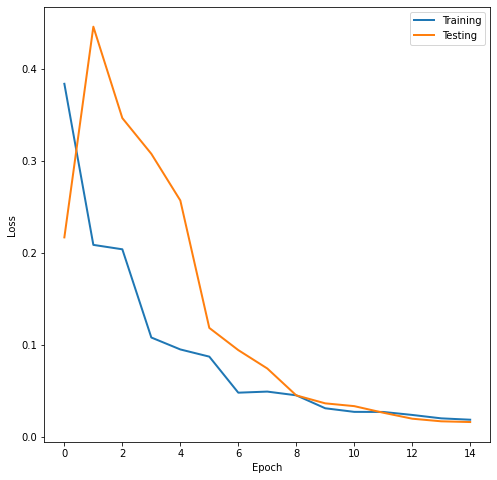

In [ ]:
# Loss curves
plt.figure(figsize=(8,8))
plt.plot(loss_vec[0], linewidth=2)
plt.plot(loss_vec[1], linewidth=2)
plt.legend(["Training" , "Testing"])
plt.xlabel('Epoch')
plt.ylabel('Loss')


Text(0, 0.5, 'Correlation')

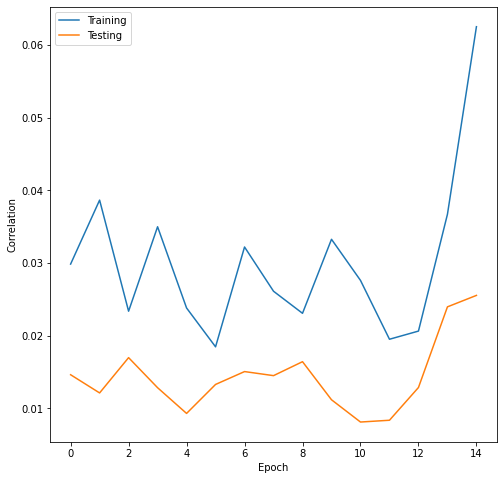

In [ ]:
# accuracy curve
plt.figure(figsize=(8,8))
plt.plot(np.array(accuracy_train))
plt.plot(np.array(accuracy_test))
plt.legend(["Training" , "Testing"])
plt.xlabel('Epoch')
plt.ylabel('Correlation')

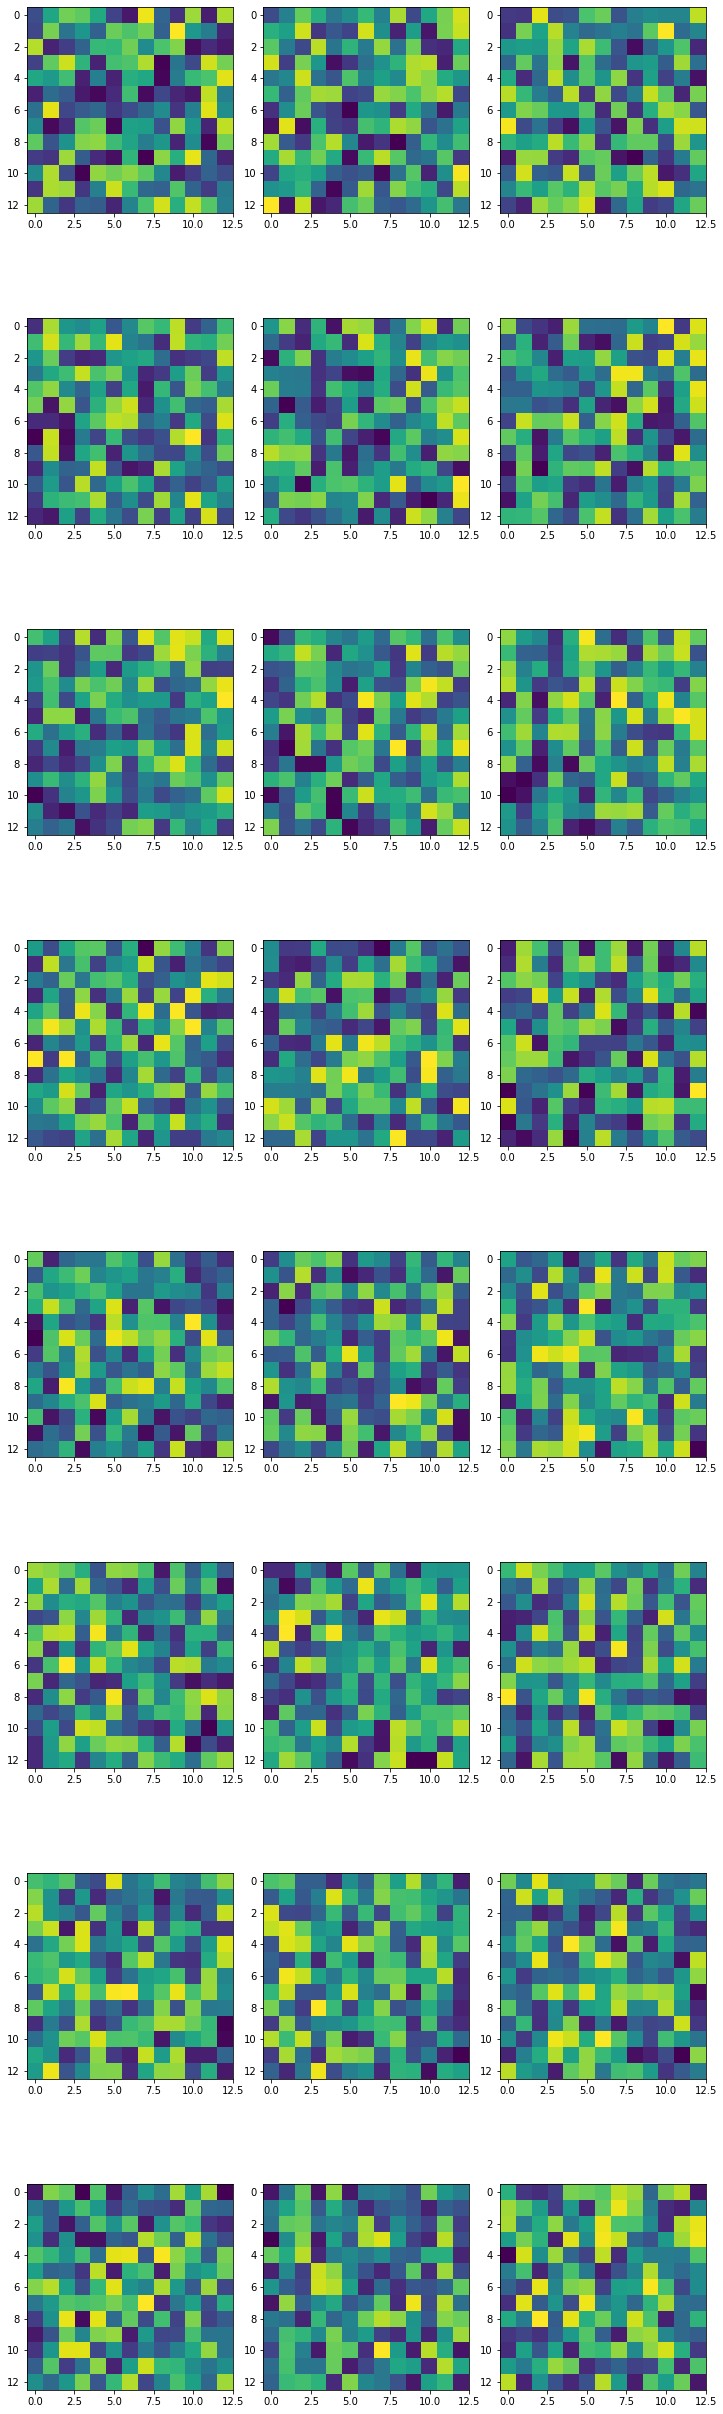

In [ ]:
#plot conv1 layer weights
conv1_weights=net.state_dict()['cnn_layers.0.weight'].cpu().detach().numpy()

plt.figure(figsize=(10,35))
for filters in range(conv1_weights.shape[0]):
  for filters2 in range(conv1_weights.shape[1]):
    plt.subplot(8,3,filters*3+filters2+1)
    plt.imshow(conv1_weights[filters,filters2,:,:]) #check channel 1 out of 3 channels in conv1 layer
plt.tight_layout()   
 

In [ ]:
# @title define convolution
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

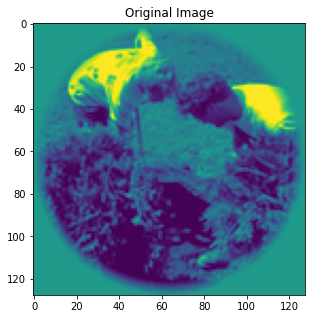

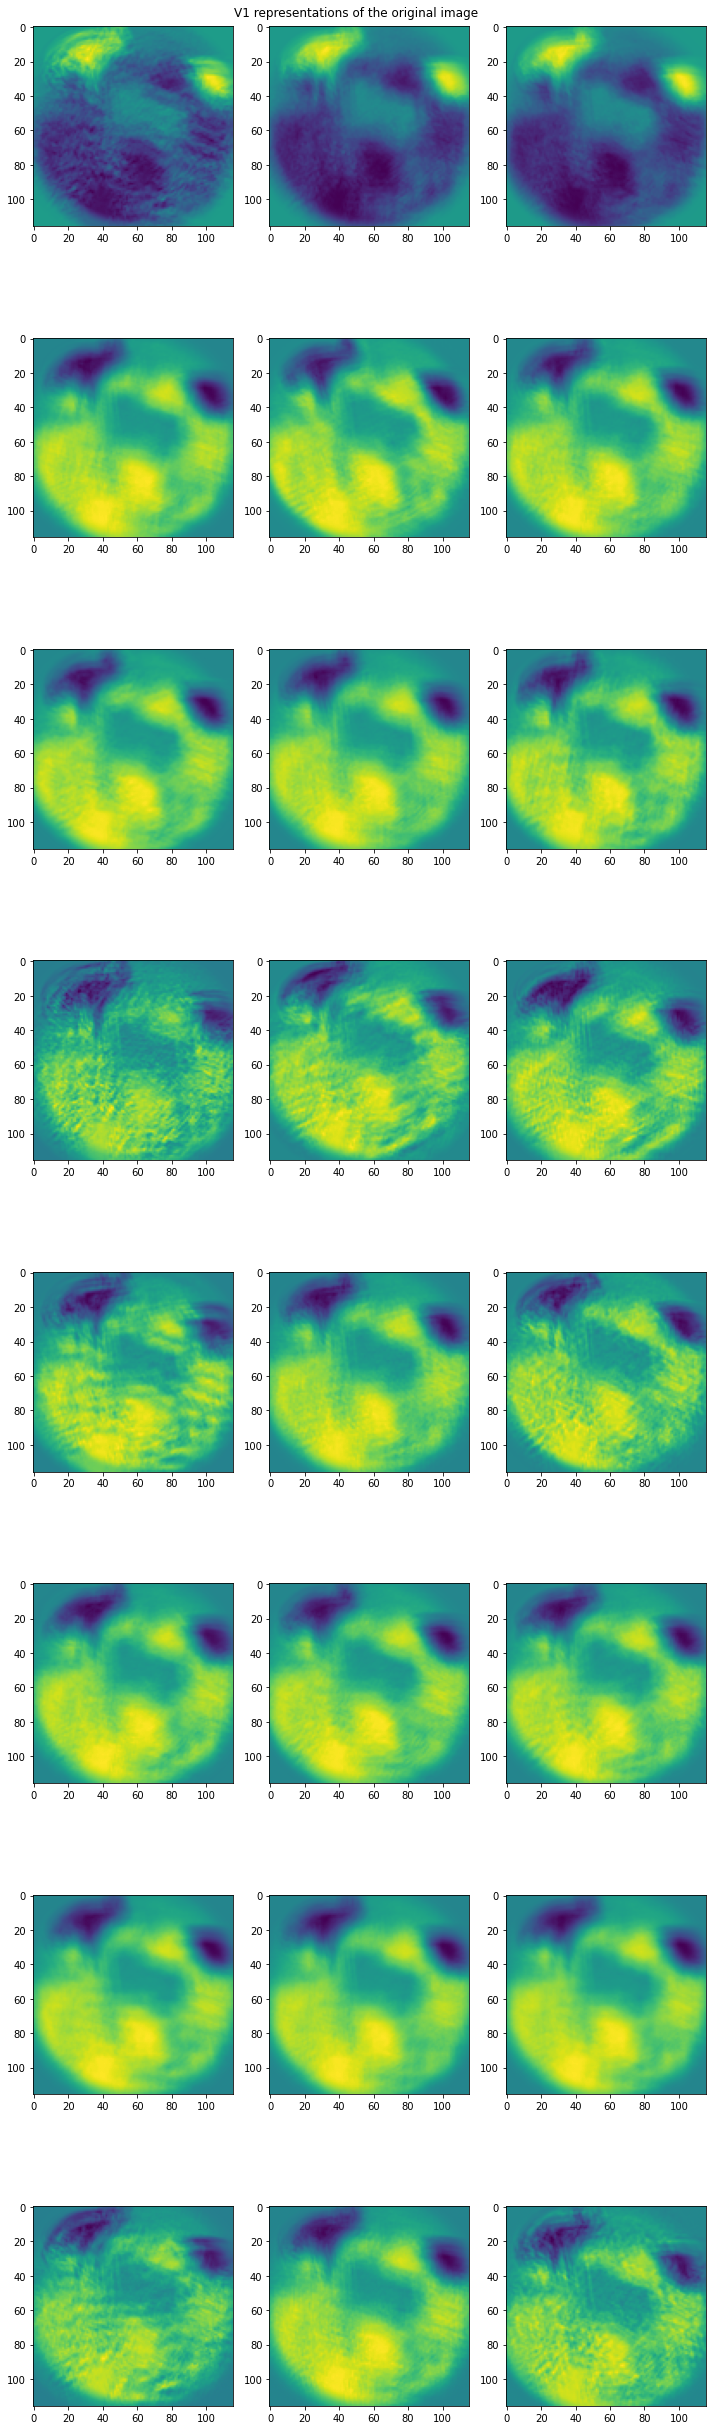

In [ ]:
# take image 1 and convolve with 2 filters to see the output
plt.figure(figsize=(15, 5))
img1=stimuli_tr[2]
plt.imshow(img1)
plt.title('Original Image')

plt.figure(figsize=(10,35))
for filters in range(conv1_weights.shape[0]):
  for filters2 in range(conv1_weights.shape[1]):
    plt.subplot(8,3,filters*3+filters2+1)
    plt.imshow(convolve2D(img1,conv1_weights[filters,filters2,:,:],padding=0)) #check channel 1 out of 3 channels in conv1 layer
plt.suptitle('V1 representations of the original image')
plt.tight_layout()  

In [ ]:
# overall VAF

# Loading validation data and forward pass through the network
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=120) for x in ['test']}
for inputs, labels in dataloaders['test']:
  inputs = inputs.to(device)
  labels = labels.cpu().detach().numpy()
  outputs=net(inputs)
  outputs = outputs.cpu().detach().numpy()

vaf=np.zeros((1,labels.shape[1]))
for vox in range(labels.shape[1]):
  pred=outputs[:,vox]
  act=labels[:,vox]
  vaf[:,vox]=np.corrcoef(pred,act)[0,1]**2

# final vaf
Final_VAF=np.mean(vaf[0,:])*100
print('Final_VAF =',Final_VAF)

Final_VAF = 0.9657443999317225
